### VAE for filters and Auxiiary ELBO

In [ ]:
import torch
import torchvision

from collections import defaultdict
import os
from tqdm import tqdm
from tqdm import tqdm_notebook
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
torch.cuda.is_available()

True

Upload filters from the first, second and third layer respectively.

In [ ]:
import pickle
path = os.path.join('drive', 'My Drive','conv1.pkl')
with open(path, 'rb') as handle:
    conv_1 = pickle.load(handle)

In [ ]:
import pickle
path = os.path.join('drive', 'My Drive','conv_2.pkl')
with open(path, 'rb') as handle:
    conv_2 = pickle.load(handle)

In [ ]:
import pickle
path = os.path.join('drive', 'My Drive','conv_3.pkl')
with open(path, 'rb') as handle:
    conv_3 = pickle.load(handle)

For these filters set out the threshold and pick out filters such that are more than it.

In [ ]:
filters_1 = conv_1.reshape(20*16*3,3,3) 
filters_2 = conv_2.reshape(20*32*16,3,3)
filters_3 = conv_3.reshape(20*64*32,3,3)

norms_1 = torch.linalg.norm(filters_1,dim=(-2,-1))
norms_2 = torch.linalg.norm(filters_2,dim=(-2,-1))
norms_3 = torch.linalg.norm(filters_3,dim=(-2,-1))
norms = list()
norms.extend([norms_1,norms_2,norms_3])

In [ ]:
mask = [torch.linalg.norm(filters_1,dim=(-2,-1)) > 0.3][0]
filters_1 = filters_1[mask]

mask = [torch.linalg.norm(filters_2,dim=(-2,-1)) > 0.3][0]
filters_2 = filters_2[mask]

mask = [torch.linalg.norm(filters_3,dim=(-2,-1)) > 0.3][0]
filters_3 = filters_3[mask]

### VAE

Now, one can prepare dataset that is composed of filters form the first layer to learn VAE for filters of the first layer our CNN

In [ ]:
# Preparing data for training of filters_1
filters_1_data = filters_1.reshape(931,1,3,3)
filters_1_data_numpy = filters_1_data.numpy()

train_data = filters_1_data_numpy[:600].astype('float32')
test_data = filters_1_data_numpy[600:].astype('float32')

BATCH_FILTER_1 = 10

train_loader = torch.utils.data.DataLoader(train_data,batch_size=BATCH_FILTER_1,shuffle=True)
test_loader =  torch.utils.data.DataLoader(test_data,batch_size=BATCH_FILTER_1)

In [ ]:
class ConvEncoder(torch.nn.Module):
  def __init__(self, z_dim = 4, hidden_dim = 64):
    super().__init__()
    
    assert isinstance(hidden_dim,int)
    assert isinstance(z_dim, int)

    self.z_dim =z_dim
    self.hidden_dim = hidden_dim

    self.features = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels = 1, out_channels = hidden_dim, kernel_size=(3,3),stride = (1,1),padding = 1 ,bias=False),
        torch.nn.ELU(alpha=1.0),

        torch.nn.Conv2d(in_channels= hidden_dim ,out_channels= hidden_dim ,kernel_size=(3,3),stride=(1,1),padding=1,bias=False),
        torch.nn.ELU(alpha=1.0),

        torch.nn.Conv2d(in_channels = hidden_dim, out_channels= 2*hidden_dim ,kernel_size=(2,2),stride=(1,1),bias=False),
        torch.nn.ELU(alpha=1.0),

        torch.nn.Conv2d(in_channels= 2*hidden_dim,out_channels= 2*hidden_dim,kernel_size=(2,2),stride=(1,1),bias=False),
        torch.nn.ELU(alpha=1.0),

         
        )
    # torch.Size([batch,128,1,1])
    self.fc_linear = torch.nn.Linear(in_features = 2 * hidden_dim * 1 * 1, out_features = 2 * z_dim  )
    # torch.Size([batch, 2*z_dim])

    #### Initial realisation ####
    #self.fc_mu = torch.nn.Conv2d(in_channels= 2*hidden_dim, out_channels=z_dim, kernel_size=(1,1),stride=(1,1),bias=False)
    #self.fc_sigma = torch.nn.Conv2d(in_channels= 2*hidden_dim,out_channels=z_dim,kernel_size=(1,1),stride=(1,1),bias=False)


  def forward(self,input):
    input = self.features(input)
    
   
    input = input.view((-1, 2*self.hidden_dim * 1 * 1))
     
    
    input = self.fc_linear(input)
    mu_z ,log_sigma_z = input.chunk(2, dim = 1)


    #### Initial realisation ####
    #mu_z = self.fc_mu(input)
    #log_sigma_z =  self.fc_sigma(input)


    return mu_z, log_sigma_z # [batch, z_dim] , [batch, z_dim]

In [ ]:
class Unflatten(torch.nn.Module):
  def __init__(self,shape):
    super().__init__()
    self.shape = shape

  def forward(self, input):
    return input.view(-1, self.shape[0], self.shape[1],self.shape[2])

In [ ]:
class ConvDecoder(torch.nn.Module):
  def __init__(self, z_dim =4 , hidden_dim = 64):
    super().__init__()

    self.z_dim = z_dim
    self.hidden_dim = hidden_dim

    self.fc_linear_unf = torch.nn.Sequential(
        torch.nn.Linear(in_features = z_dim , out_features = 2* hidden_dim * 1 * 1 ),
        Unflatten((2*hidden_dim,1,1)) )

    self.features = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels = 2*hidden_dim * 1 * 1, out_channels = 2*hidden_dim, kernel_size= (1,1), stride=(1,1),bias=False),
        #torch.nn.BatchNorm2d(2*hidden_dim),
        torch.nn.ELU(alpha=1.0),

        torch.nn.ConvTranspose2d(in_channels = 2*hidden_dim ,out_channels = hidden_dim, kernel_size =(3,3),stride=(1,1),bias=False ),
        #torch.nn.BatchNorm2d(hidden_dim),
        torch.nn.ELU(alpha=1.0),

        torch.nn.Conv2d(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=(1,1),stride=(1,1),bias=False),
        torch.nn.ELU(alpha=1.0),


    )
    ## Tensor.Size([batch, hidden_dim, 3, 3])
    self.conva = torch.nn.Sequential(
        torch.nn.ConvTranspose2d(in_channels = hidden_dim ,out_channels = 1 ,kernel_size = (1,1), stride = (1,1) ,bias=False)
    )
    ## Tensor.Size([batch,1,3,3])
    self.fc_lin = torch.nn.Linear(in_features = hidden_dim*3*3, out_features = 2*1*3*3)

    ### Initial realisation ###
    #self.fc_mu = torch.nn.Conv2d(in_channels = hidden_dim, out_channels=1, kernel_size = (1,1), stride = 1, bias=False )
    #self.fc_var = torch.nn.Conv2d(in_channels= hidden_dim,out_channels=1,  kernel_size = (1,1), stride = 1 , bias=False )





  def forward(self,input):
    input = self.fc_linear_unf(input)
    input = self.features(input)
    reconstruction = self.conva(input)

    input = input.view(-1,self.hidden_dim*3*3)
    input = self.fc_lin(input)

    mu_x, log_sigma_x = input.chunk(2 , dim = 1)

    return mu_x, log_sigma_x, reconstruction # [batch,9],[batch,9],[batch,1,3,3]

In [ ]:
class VAE(torch.nn.Module):
  def __init__(self, z_dim = 4, hidden_dim = 64):
    super().__init__()

    self.z_dim =z_dim
    self.hidden_dim = hidden_dim

    self.encoder = ConvEncoder(z_dim , hidden_dim)
    self.decoder = ConvDecoder(z_dim , hidden_dim)

  def prior(self, batch_size):
    return torch.randn(batch_size, self.z_dim).cuda()

  
  def forward(self,input):
    mu_z,log_std_z = self.encoder(input)
    # reparametrization trick
    z = mu_z + log_std_z.exp()*self.prior(input.shape[0])
    mu_x, log_std_x, x_recon = self.decoder(z)
    return mu_z, log_std_z, x_recon , mu_x , log_std_x

  def loss(self,input):
    mu_z,log_std_z,x_recon = self.forward(input)[0],self.forward(input)[1],self.forward(input)[2]
    mu_x,log_std_x = self.forward(input)[3],self.forward(input)[4]
    # input : torch.Size([batch,1,3,3])
    # x_recon: torch.Size([batch,1,3,3])

     
    x_recon_ = mu_x + log_std_x.exp()*torch.randn(input.shape[0],3*3).cuda()
    x_recon_ = x_recon_.view(-1,1,3,3)
    
    #x_recon_ = x_recon_.reshape(10,1,3,3)

    recon_loss = torch.nn.functional.mse_loss(x_recon_, input, reduction = 'none')#.sum(1).mean()
    recon_loss = recon_loss.view(input.shape[0],-1).sum(1).mean()


    kl_loss = 0.5*(log_std_z.exp()**2 + mu_z.pow(2) - 1 - log_std_z)
    kl_loss = kl_loss.sum(1).mean()

    return {'elbo_loss': recon_loss + kl_loss , 'recon_loss' : recon_loss ,'kl_loss' : kl_loss }
  
  def sample(self, batch_size):
    # sampling reconstruction images
    pass

In [ ]:
def train_epoch(model,train_loader,optimizer,epoch,loss_key='total'):
  
  model.train()
  stats = defaultdict(list)

  for x in train_loader:
    x = x.cuda()
    optimizer.zero_grad()
    losses = model.loss(x)
    losses[loss_key].backward()
    optimizer.step()

    for k,v in losses.items():
      stats[k].append(v.item())
  return stats

In [ ]:
def eval_model(model , data_loader):

  model.eval()
  stats = defaultdict(float)

  with torch.no_grad():
    for x in data_loader:
      x= x.cuda()
      losses = model.loss(x)
      for k,v in losses.items():
        stats[k]+=v.item()*x.shape[0]
    
    for k in stats.keys():
      stats[k] /= len(data_loader.dataset)
  return stats

In [ ]:
def train_model(model, train_loader, test_loader, epochs, lr, loss_key='total'):

  optimizer = torch.optim.Adam(model.parameters(),lr=lr)
  train_losses = defaultdict(list)
  test_losses =  defaultdict(list)
  
  for epoch in range(epochs):
    model.train()
    train_loss = train_epoch(model,train_loader,optimizer,epoch,loss_key)
    test_loss = eval_model(model,test_loader)

    for k in train_loss.keys():
      train_losses[k].extend(train_loss[k])
      test_losses[k].append(test_loss[k])
  return dict(train_losses), dict(test_losses)

In [ ]:
def plot_training_curves(train_losses, test_losses):
  n_train = len(train_losses[list(train_losses.keys())[0]])
  n_test = len(test_losses[list(train_losses.keys())[0]])
  x_train = np.linspace(0, n_test - 1, n_train)
  x_test = np.arange(n_test)

  plt.figure()
  for key, value in train_losses.items():
    plt.plot(x_train, value, label=key + '_train')

  for key, value in test_losses.items():
    plt.plot(x_test, value, label=key + '_test')

  plt.legend()
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.show()

In [ ]:
LR = 1e-4
EPOCHS = 5
model_1 = VAE(4,64).cuda()
train_losses, test_losses = train_model(
    model_1, train_loader, test_loader, epochs=EPOCHS, lr=LR, loss_key='elbo_loss'
)

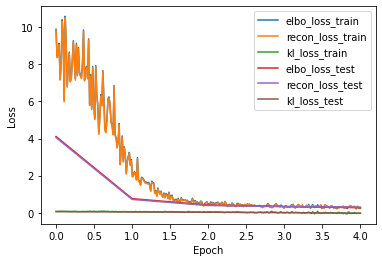

In [ ]:
plot_training_curves(train_losses, test_losses)

Now, one can repeat these actions for filters of the second layer and train VAE for filters of the second layer of CNN

In [ ]:
# Preparing data for training of filters_2
filters_2_data = filters_2.reshape(6783,1,3,3)
filters_2_data_numpy = filters_2_data.numpy()

train_data = filters_2_data_numpy[:5500].astype('float32')
test_data = filters_2_data_numpy[5500:].astype('float32')

BATCH_FILTER_2 = 25

train_loader = torch.utils.data.DataLoader(train_data,batch_size=BATCH_FILTER_2,shuffle=True)
test_loader =  torch.utils.data.DataLoader(test_data,batch_size=BATCH_FILTER_2)

In [ ]:
LR = 1e-5
EPOCHS = 5
model_2 = VAE(4,64).cuda()
train_losses, test_losses = train_model(
    model_2, train_loader, test_loader, epochs=EPOCHS, lr=LR, loss_key='elbo_loss'
)

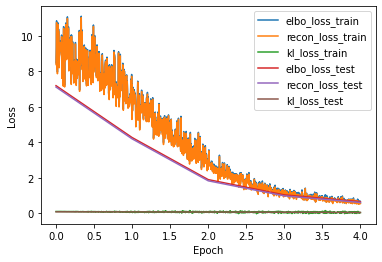

In [ ]:
plot_training_curves(train_losses,test_losses)

The same for filters of the third layer of CNN

In [ ]:
# Preparing data for training of filters_2
filters_3_data = filters_3.reshape(29083,1,3,3)
filters_3_data_numpy = filters_3_data.numpy()

train_data = filters_3_data_numpy[:25000].astype('float32')
test_data = filters_3_data_numpy[25000:].astype('float32')

BATCH_FILTER_3 = 50

train_loader = torch.utils.data.DataLoader(train_data,batch_size=BATCH_FILTER_3,shuffle=True)
test_loader =  torch.utils.data.DataLoader(test_data,batch_size=BATCH_FILTER_3)

In [ ]:
LR = 1e-5
EPOCHS = 5
model_3 = VAE(4,64).cuda()
train_losses, test_losses = train_model(
    model_3, train_loader, test_loader, epochs=EPOCHS, lr=LR, loss_key='elbo_loss'
)

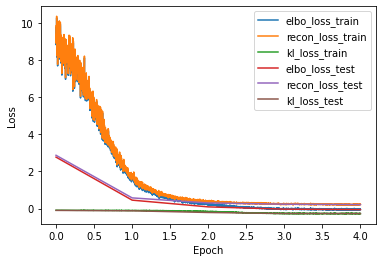

In [ ]:
plot_training_curves(train_losses,test_losses)

### Auxiliary ELBO

In [ ]:
#### Decoder ####
# mu_x = model_1(torch.randn(1,9).view(-1,1,3,3))[3].detach() [batch,9]
# log_std_x = model_1(torch.randn(1,9).view(-1,1,3,3))[3].detach() [batch,9]

#### Encoder ####
# mu_z = model_1(torch.randn(1,9).view(-1,1,3,3))[0] [batch,4]
# log_std_z = model_1(torch.randn(1,9).view(-1,1,3,3))[1] [batch,4]



As soon as we train VAE for each filters , one can get distributions of encoder and decoder as follow:
$$ Encoder: r(z|\omega,\psi) = \mathcal{N}(\mu_{z},\Sigma_{z})$$
$$ Decoder: p(\omega|z,\phi) = \mathcal{N}(\mu_{x},\Sigma_{x})$$
It is worth worth noticing, that covariance matrix $\Sigma_{z}$ is represented as $\sigma_{z}* I_{9}$ , where $\sigma_{z}$ is a vector that is composed of 9 diagonal elements of covariance matrix. 

By the way, one can see how  we have to obtain parametrs of distributions of encoder and decoder from a trained model.

Since prior and variance distribution are factorized through all filters i.e. each filter from a layer has own parameters of gaussian distribution. Then , let's define a matrix that is composed of all means and all diagonal elements in each layer. Thus, MU_1 and LOG_SIGMA_1 are composed of all means and all diagonal elements of covariance matrix for all 931 filters in the first layer.

In [3]:
# parameters of q(w|\theta) for each filter in each layer
MU_1 = torch.randn(931,9,requires_grad=True)#.cuda()
LOG_SIGMA_1 = torch.randn(931,9,requires_grad=True)#.cuda()

MU_2 = torch.randn(6783,9,requires_grad=True)#.cuda()
LOG_SIGMA_2 = torch.randn(6783,9,requires_grad=True)#.cuda()

MU_3 = torch.randn(29083,9,requires_grad=True)#.cuda()
LOG_SIGMA_3 = torch.randn(29083,9,requires_grad=True)#.cuda()

The following function creates one element of $ D_{kl}^{bound} $. The first subfunction  creates entropy term. 



The second term is corresponded to the Monte-Carlo estimation as follow:
$$ \mathbb{E}_{q(\omega|\theta)} KL(r(z|\omega, \psi) || p_{l}(z)) = \frac{1}{L}\sum_{i = 1}^{L} KL(r(z|\omega_{i},\psi)|| p_{l}(z))$$ , where $\omega_{i}$ is sampled L times from $q(\omega_{i}| \theta)$ 

The third term is obtained the same
$$ \mathbb{E}_{q(\omega|\theta)} \mathbb{E}_{r(z|\omega,\psi)} \log P(\omega|z,\phi) = \frac{1}{L} \sum_{i=1}^{L} \frac{1}{S} \sum_{j=1}^{S} \log P(\omega_{i}|z_{j},\phi) $$
Where $z_{j}$ is sampled S times from $r(z|\omega_{i},\phi)$ , meanwhile $w_{i}$ is sampled Ltimes from $q(w|\theta)$

In [ ]:
def elements_of_layer(MU, LOG_SIGMA, model,count_of_samples = 3):

  ### entropy_term first layer ###
  entropy_first_layer = torch.tensor([])
  for each_log_sigma in LOG_SIGMA:
    entropy_first_layer = torch.cat([entropy_first_layer,\
                                     -0.5*torch.sum(torch.log(each_log_sigma.exp())).view(-1)])#.cuda()
  ## entropy_first_layer torch.Size([931])


  #### second term ####
  second_term = torch.tensor([])#.cuda()
  for each_mu, each_log_sigma in tqdm_notebook(zip(MU,LOG_SIGMA)):
    kl_losses = torch.tensor([])
    for count in range(count_of_samples):
      sample = each_mu + each_log_sigma.exp()*torch.randn(9).cuda()
      sample = sample.view(-1,1,3,3)
      mu_z, log_std_z = model(sample)[0],model(sample)[1]
      ## kl-divergence
      kl_loss = 0.5*(log_std_z.exp()**2 + mu_z.pow(2) - 1 - log_std_z)
      kl_loss = kl_loss.sum(1).mean()
      kl_losses = torch.cat([kl_losses,kl_loss.view(-1)])#.cuda()
    second = torch.sum(kl_losses).mean()#.cuda()
    second_term = torch.cat([second_term,second.view(-1)])#.cuda()
  ## second_term torch.Size([931])


  ### third  term ###
  third_term = torch.tensor([])#.cuda()
  for each_mu , each_log_sigma in tqdm_notebook(zip(MU, LOG_SIGMA) ):
    target_subterm = torch.tensor([])#.cuda()
    for count in range(count_of_samples):
      sample_q = each_mu + each_log_sigma.exp()*torch.randn(9).cuda()
      sample_q = sample_q.view(-1,1,3,3)
      func_z = torch.tensor([])#.cuda()
      for count in range(count_of_samples):
        mu_z , log_std_z = model(sample_q)[0],model(sample_q)[1]
        sample_z = mu_z + log_std_z.exp()*torch.randn(4)#.cuda()
        mu_x, log_std_x = model(sample_q)[3].detach(), model(sample_q)[4].detach()
        sample_qq =sample_q.view(-1,9)#.cuda()
        ### Cholesky CPU
        log_proba = torch.distributions.multivariate_normal.MultivariateNormal(loc = mu_x, covariance_matrix = log_std_x.exp()*torch.eye(9)).log_prob(sample_qq)#.cuda()
        func_z = torch.cat([func_z, log_proba.view(-1)])#.cuda()
      target = torch.sum(func_z).mean()#.cuda()
      target_subterm  = torch.cat([target_subterm,target.view(-1)])#.cuda()
    third = torch.sum(target_subterm).mean()#.cuda()
    third_term = torch.cat([third_term,third.view(-1)])#.cuda()

  return entropy_first_layer, second_term, third_term




### Loss for $D_{kl}$ bound

In [ ]:
optimizer = torch.optim.Adam([MU_1,LOG_SIGMA_1, MU_2,LOG_SIGMA_2, MU_3,LOG_SIGMA_3],lr=1e-3)
optim_1 = torch.optim.Adam(model_1.parameters(), lr=1e-3)
optim_2 = torch.optim.Adam(model_2.parameters(), lr=1e-3)
losses = []
for i in tqdm_notebook(range(20)):
  answer_1 = elements_of_layer(MU_1,LOG_SIGMA_1 ,model_1, 3)
  answer_2 = elements_of_layer(MU_2,LOG_SIGMA_2 ,model_2, 3)

  loss = (torch.sum(answer_1[0]) \
  + torch.sum(answer_1[1])\
  + torch.sum( answer_1[2] ) +\
  torch.sum(answer_2[0]) +\
  torch.sum( answer_2[1]) +\
  torch.sum( answer_2[2])  )
  loss.backward()
  losses.append(loss.item())
  optimizer.step()
  optim_1.step()
  optim_2.step()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


RuntimeError: ignored